In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from glob import glob
import cv2
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!unzip -q /content/leaf-classification.zip

# **Part1 Data Preparation**

## **1.data description**

**About 1,584 photos of leaf specimens—16 samples each from 99 different species—that have been transformed into binary black leaves against white backgrounds make up the dataset. Each image additionally has three sets of features: a fine-scale margin histogram, an interior texture histogram, and a shape contiguous descriptor. Every leaf sample has a 64-attribute vector for every characteristic.**

**one species has removed from the original 100 due to missing associated data in the original dataset.**


*   id - an anonymous id unique to an image.
*   margin_1, margin_2, margin_3, ..., margin_64 - each of the 64 attribute vectors for the margin feature.
*   shape_1, shape_2, shape_3, ..., shape_64 - each of the 64 attribute vectors for the shape feature.
*   texture_1, texture_2, texture_3, ..., texture_64 - each of the 64 attribute vectors for the texture feature.












In [4]:
train_data=pd.read_csv('/content/train.csv.zip')
test_data=pd.read_csv('/content/test.csv.zip')

In [ ]:
train_data.head(5)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


**all columns are numerical except species**

In [ ]:
train_data.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


## **Clean Data**

### **1.2.1 Data types**





In [ ]:
train_data.dtypes

id             int64
species       object
margin1      float64
margin2      float64
margin3      float64
              ...   
texture60    float64
texture61    float64
texture62    float64
texture63    float64
texture64    float64
Length: 194, dtype: object

**all columns are numerical except Species(target):which we can encoding in next steps**

### **1.2.2 Checking for Outliers**

In [ ]:
train_data.describe(percentiles=[.025, .975])

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.5%,37.725000,0.000000,0.000000,0.001953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
97.5%,1547.275000,0.068359,0.140630,0.100146,0.117190,0.072266,0.180226,0.063037,0.007812,0.037109,...,0.223899,0.054956,0.078125,0.093750,0.056641,0.158691,0.038354,0.123050,0.048828,0.079639
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


**There are some outliers but they have minimal impact**

### **1.3.1checking for nulls**

In [ ]:
train_data.isna().sum()

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64

In [ ]:
test_data.isna().sum()

id           0
margin1      0
margin2      0
margin3      0
margin4      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 193, dtype: int64

**No nulls**

### **1.3.2checking for duplicates**

In [ ]:
train_data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
985    False
986    False
987    False
988    False
989    False
Length: 990, dtype: bool

In [ ]:
test_data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
589    False
590    False
591    False
592    False
593    False
Length: 594, dtype: bool

**No Dublicates**

### **1.3.3 number of classes**

In [ ]:
no_class=train_data.species.nunique()
no_class

99

## **1.4.Visualization of the data**

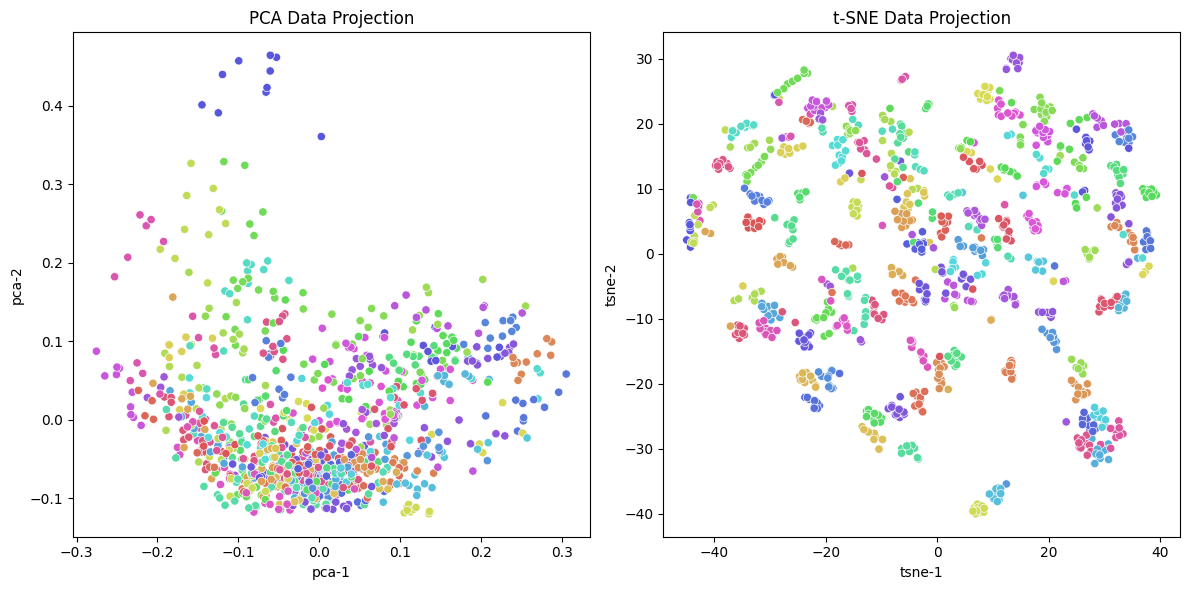

In [8]:
features = train_data.drop(columns=['species', 'id'])
target = train_data['species']
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_components, columns=['pca-1', 'pca-2'])
pca_df['species'] = target
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(features)
tsne_df = pd.DataFrame(tsne_embeddings, columns=['tsne-1', 'tsne-2'])
tsne_df['species'] = target
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='pca-1', y='pca-2', hue='species', palette='hls', legend=False)
plt.title('PCA Data Projection')
plt.subplot(1, 2, 2)
sns.scatterplot(data=tsne_df, x='tsne-1', y='tsne-2', hue='species', palette='hls', legend=False)
plt.title('t-SNE Data Projection')
plt.tight_layout()
plt.show()

## **1.5.drawing some images**

In [ ]:
!unzip -q /content/images.zip

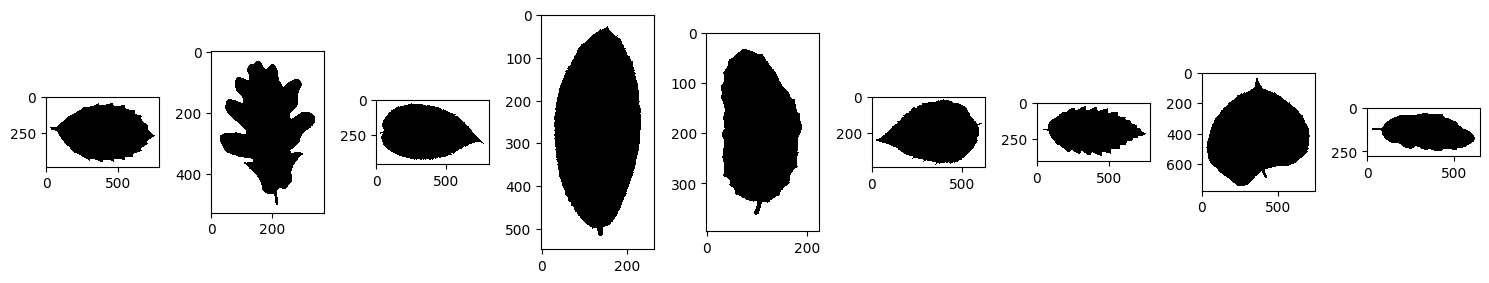

In [ ]:
images=[]
files = glob('/content/images/*.jpg')
for i in files:
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    if image is not None:  # Check if image is successfully read
            images.append(image)
fig, axes = plt.subplots(1, 9, figsize=(15, 3))
for j, ax in enumerate(axes):
    ax.imshow(images[j], cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.show()


## **1.6. Carry out required correlation analysis**

In [ ]:
correlation_matrix = train_data.corr()
print(correlation_matrix)

                 id   margin1   margin2   margin3   margin4   margin5  \
id         1.000000 -0.011673 -0.027565 -0.059533  0.001639 -0.002419   
margin1   -0.011673  1.000000  0.806390 -0.182829 -0.297807 -0.475874   
margin2   -0.027565  0.806390  1.000000 -0.204640 -0.315953 -0.444312   
margin3   -0.059533 -0.182829 -0.204640  1.000000  0.120042 -0.185007   
margin4    0.001639 -0.297807 -0.315953  0.120042  1.000000  0.029480   
...             ...       ...       ...       ...       ...       ...   
texture60 -0.000823  0.035072  0.081069 -0.019850 -0.052317  0.006542   
texture61  0.026319 -0.007581 -0.007057  0.084957  0.320644 -0.109229   
texture62  0.032873 -0.033159 -0.037405 -0.081999 -0.073886  0.151675   
texture63  0.024299 -0.075171 -0.098957 -0.148193  0.050970  0.022299   
texture64  0.035396  0.030414 -0.029532  0.061780  0.014343 -0.148834   

            margin6   margin7   margin8   margin9  ...  texture55  texture56  \
id        -0.051818  0.061214 -0.039509 -0.

<ipython-input-47-93430e3601ba>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


In [ ]:
upper_triangle = correlation_matrix.where(~np.tril(np.ones(correlation_matrix.shape)).astype(bool))
threshold = 0.9
columns_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
if columns_to_drop:
    print("Columns with correlation greater than", threshold, ":")
    print(columns_to_drop)
else:
    print("No columns found with correlation greater than", threshold)


Columns with correlation greater than 0.9 :
['shape2', 'shape3', 'shape4', 'shape5', 'shape6', 'shape7', 'shape8', 'shape9', 'shape10', 'shape11', 'shape12', 'shape13', 'shape14', 'shape15', 'shape16', 'shape17', 'shape18', 'shape19', 'shape20', 'shape21', 'shape22', 'shape23', 'shape24', 'shape25', 'shape26', 'shape27', 'shape28', 'shape29', 'shape30', 'shape31', 'shape32', 'shape33', 'shape34', 'shape35', 'shape36', 'shape37', 'shape38', 'shape39', 'shape40', 'shape41', 'shape42', 'shape43', 'shape44', 'shape45', 'shape46', 'shape47', 'shape48', 'shape49', 'shape50', 'shape51', 'shape52', 'shape53', 'shape54', 'shape55', 'shape56', 'shape57', 'shape58', 'shape59', 'shape60', 'shape61', 'shape62', 'shape63', 'shape64']


**notice shape_2, shape_3, ..., shape_64  with high correlation
A set of highly correlated attributes will add to the algorithm's complexity rather than provide any new information, or very little of it.so we will drop them.**

In [ ]:
train_data=train_data.drop(columns_to_drop,axis=1)
test_data=test_data.drop(columns_to_drop,axis=1)
train_data

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.000000,0.000000,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.000000,0.000000,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.000000,0.000000,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.000000,0.000000,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930


In [ ]:
train_data.describe().keys()

Index(['id', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=130)

In [ ]:
train_data['species']

0                Acer_Opalus
1      Pterocarya_Stenoptera
2       Quercus_Hartwissiana
3            Tilia_Tomentosa
4         Quercus_Variabilis
               ...          
985     Magnolia_Salicifolia
986              Acer_Pictum
987       Alnus_Maximowiczii
988            Quercus_Rubra
989           Quercus_Afares
Name: species, Length: 990, dtype: object

In [ ]:
test_data.describe().keys()

Index(['id', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=130)

## **2.Data Division to data and target**

In [ ]:
x_train=train_data.drop(['species','id'],axis=1).values
y_train=train_data['species'].values
x_test=test_data.drop('id',axis=1).values


In [ ]:
y_train

array(['Acer_Opalus', 'Pterocarya_Stenoptera', 'Quercus_Hartwissiana',
       'Tilia_Tomentosa', 'Quercus_Variabilis', 'Magnolia_Salicifolia',
       'Quercus_Canariensis', 'Quercus_Rubra', 'Quercus_Brantii',
       'Salix_Fragilis', 'Zelkova_Serrata', 'Betula_Austrosinensis',
       'Quercus_Pontica', 'Quercus_Afares', 'Quercus_Coccifera',
       'Fagus_Sylvatica', 'Phildelphus', 'Acer_Palmatum',
       'Quercus_Pubescens', 'Populus_Adenopoda', 'Quercus_Trojana',
       'Quercus_Variabilis', 'Alnus_Sieboldiana', 'Quercus_Ilex',
       'Arundinaria_Simonii', 'Acer_Platanoids', 'Quercus_Phillyraeoides',
       'Cornus_Chinensis', 'Quercus_Phillyraeoides', 'Fagus_Sylvatica',
       'Liriodendron_Tulipifera', 'Cytisus_Battandieri',
       'Tilia_Tomentosa', 'Rhododendron_x_Russellianum', 'Alnus_Rubra',
       'Eucalyptus_Glaucescens', 'Cercis_Siliquastrum',
       'Cotinus_Coggygria', 'Celtis_Koraiensis', 'Quercus_Crassifolia',
       'Quercus_Variabilis', 'Quercus_Hartwissiana', 'Quercus

## **3.Data Standarization**

### **3.1.Mean**  

In [ ]:
x_train.mean(axis=0)

array([0.01741236, 0.02853929, 0.03198784, 0.02327962, 0.01426367,
       0.03857921, 0.01920174, 0.00108304, 0.00716723, 0.01863949,
       0.02420885, 0.01197516, 0.04125242, 0.00805311, 0.01560917,
       0.00011048, 0.01512781, 0.02010729, 0.01234407, 0.0131352 ,
       0.0191307 , 0.00619471, 0.00099825, 0.00764673, 0.00885411,
       0.01871843, 0.00562849, 0.0155342 , 0.0282611 , 0.01650088,
       0.01084274, 0.00969061, 0.01950161, 0.00108303, 0.01316678,
       0.01804171, 0.01626813, 0.03106059, 0.01484568, 0.0081636 ,
       0.01088417, 0.01749522, 0.01885847, 0.01267946, 0.02468824,
       0.01005753, 0.02531954, 0.02700242, 0.00856017, 0.01398157,
       0.02565692, 0.00276391, 0.02400172, 0.01000232, 0.01819164,
       0.00595992, 0.01255912, 0.02019014, 0.03095009, 0.01185087,
       0.00138881, 0.00498337, 0.02538862, 0.00437374, 0.00073932,
       0.02194408, 0.01168819, 0.01031409, 0.01539027, 0.02694037,
       0.00988006, 0.01671207, 0.01956183, 0.01492168, 0.01996

### **3.2.Standard Deviation**

In [ ]:
x_train.std(axis=0)

array([0.01972903, 0.03883528, 0.02583378, 0.02839691, 0.01838047,
       0.05200325, 0.01750202, 0.00274142, 0.00892818, 0.01606324,
       0.02607237, 0.01172651, 0.04631774, 0.01326638, 0.0142693 ,
       0.00105128, 0.01081596, 0.02127466, 0.01447174, 0.0096676 ,
       0.01945333, 0.01019777, 0.00430752, 0.01285779, 0.01271793,
       0.01230684, 0.01085134, 0.01409297, 0.02284041, 0.01655202,
       0.01655434, 0.01928113, 0.01599198, 0.00208707, 0.01321092,
       0.01645565, 0.01147804, 0.02325842, 0.01323505, 0.01018932,
       0.02343338, 0.01446406, 0.02092487, 0.01168018, 0.02430518,
       0.0128828 , 0.02144355, 0.0301128 , 0.01597111, 0.01760248,
       0.02487512, 0.00764204, 0.01820228, 0.01553795, 0.02182706,
       0.00883083, 0.00984638, 0.01883791, 0.031895  , 0.01246024,
       0.00229191, 0.01034146, 0.01979866, 0.00924686, 0.00027214,
       0.04402054, 0.01709483, 0.01293083, 0.02201838, 0.03801356,
       0.02042824, 0.02135093, 0.02470253, 0.02249962, 0.03741

### **3.3.standarize the data by mean and standard deviation**

In [ ]:
scaled_x_train=(x_train-x_train.mean(axis=0))/(x_train.std(axis=0))
scaled_x_test=(x_test-x_test.mean(axis=0))/x_test.std(axis=0)
print (scaled_x_train)

[[-0.68359611 -0.73095916 -0.53338158 ...  1.85223123 -0.45590536
  -0.85795418]
 [-0.88059944 -0.73095916 -1.07407824 ...  0.11664222 -0.66607024
  -0.35255267]
 [-0.78209778 -0.68146085  0.00731508 ... -0.35445674  2.48604437
   2.25863812]
 ...
 [ 2.37015724  2.73417625 -0.76509177 ... -0.20567528 -0.66607024
   2.38495615]
 [-0.88059944 -0.73095916 -0.8423285  ...  2.3977717  -0.17573333
  -0.85795418]
 [-0.78209778 -0.58246422 -0.91960478 ... -0.1808953   0.45468959
   0.57398081]]


## **4.Encoding the labels**

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_train = y_train_encoded.astype('float32')
y_train = to_categorical(y_train, num_classes=99)


# **Part2 Training a Neural Network**


## **2.1.Splitting data**

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42)
x_val,x_test,y_val,y_test=train_test_split(x_val,y_val,test_size=0.4,random_state=42)

## **2.2.Building Model Function**

In [ ]:
def training(x_t, x_v, y_t, y_v, optimizer=Adam , drop=0, weight_decay=0, batch_size=32, nodes=128, epochs=100,learning_rate=0.001):
    model = Sequential()
    model.add(Dense(nodes, activation='tanh', input_shape=(129,), kernel_regularizer=regularizers.l2(weight_decay),bias_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(drop))
    model.add(Dense(99, activation='softmax'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
    history = model.fit(x_t, y_t, epochs=epochs, batch_size=batch_size, validation_data=(x_v, y_v), verbose=0, callbacks=[early_stopping])
    return model, history

## **2.3.Building Evaluation Function**

In [ ]:
def evaluation (x_t,x_test,y_t,y_test,model):
  train_accuracy=model.evaluate(x_t,y_t)[1]
  test_accuracy=model.evaluate(x_test,y_test)[1]
  print ('the training accuracy=',train_accuracy)
  print ('the testing accuracy=',test_accuracy)
  return train_accuracy,test_accuracy

## **2.4.Building Graphing Function**

In [ ]:
def graph (col,ylabl,title,labl):
  fig, ax = plt.subplots(figsize=(10, 5))
  min_length = min(len(history0.history[col]), len(history1.history[col]), len(history2.history[col]))
  ax.plot(np.arange(min_length), history0.history[col][:min_length], label=labl[0], linewidth=3)
  ax.plot(np.arange(min_length), history1.history[col][:min_length], label=labl[1], linewidth=3)
  ax.plot(np.arange(min_length), history2.history[col][:min_length], label=labl[2], linewidth=3)
  ax.set_xlabel('Epoch')
  ax.set_ylabel(ylabl)
  ax.set_title(title)
  ax.legend()
  plt.tight_layout()
  plt.show()

## **2.5.Comparing between Normalized data and Scaled data**

### **2.5.1Training the model with normalized data using BGD**

In [ ]:
x_train.shape

(792, 129)

In [ ]:
model,history=training(x_train,x_val,y_train,y_val,batch_size=673,epochs=500)

In [ ]:
evaluation(x_train,x_test,y_train,y_test,model)

3/3 [==============================] - 0s 5ms/step - loss: 0.2378 - accuracy: 0.9500
the training accuracy= 1.0
the testing accuracy= 0.949999988079071


(1.0, 0.949999988079071)

### **2.5.2.Training model with scaled data using BGD**


In [ ]:
scaled_x_train,scaled_x_val,y_train,y_val=train_test_split(scaled_x_train,y_train,test_size=0.2,random_state=42)
scaled_x_val,scaled_x_test,y_val,y_test=train_test_split(scaled_x_val,y_val,test_size=0.4,random_state=42)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,batch_size=673,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 9ms/step - loss: 0.1271 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

**scaled data acheived higher accuracy in testing so we will use it .**

## **2.6.Hyperparameters**

### **2.6.1.Batch Size**
using MBGD as the best we can try for tunning batch size

In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,batch_size=32,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 8ms/step - loss: 0.1397 - accuracy: 0.9688
the training accuracy= 1.0
the testing accuracy= 0.96875


(1.0, 0.96875)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,batch_size=64,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 8ms/step - loss: 0.1580 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,batch_size=128,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 8ms/step - loss: 0.1231 - accuracy: 0.9844
the training accuracy= 1.0
the testing accuracy= 0.984375


(1.0, 0.984375)

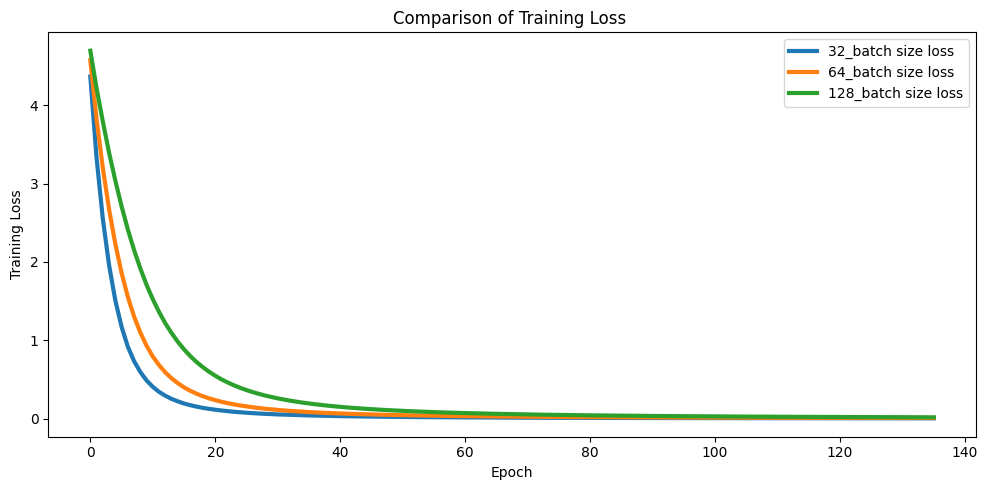

In [ ]:
labl=np.array(['32_batch size loss','64_batch size loss','128_batch size loss'])
graph('loss','Training Loss','Comparison of Training Loss ', labl)

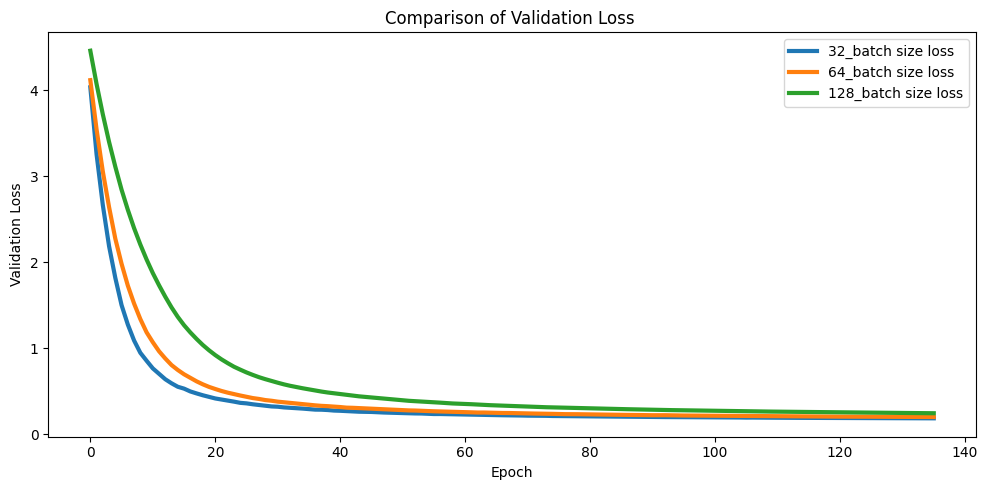

In [ ]:
labl=np.array(['32_batch size loss','64_batch size loss','128_batch size loss'])
graph('val_loss','Validation Loss','Comparison of Validation Loss ', labl)

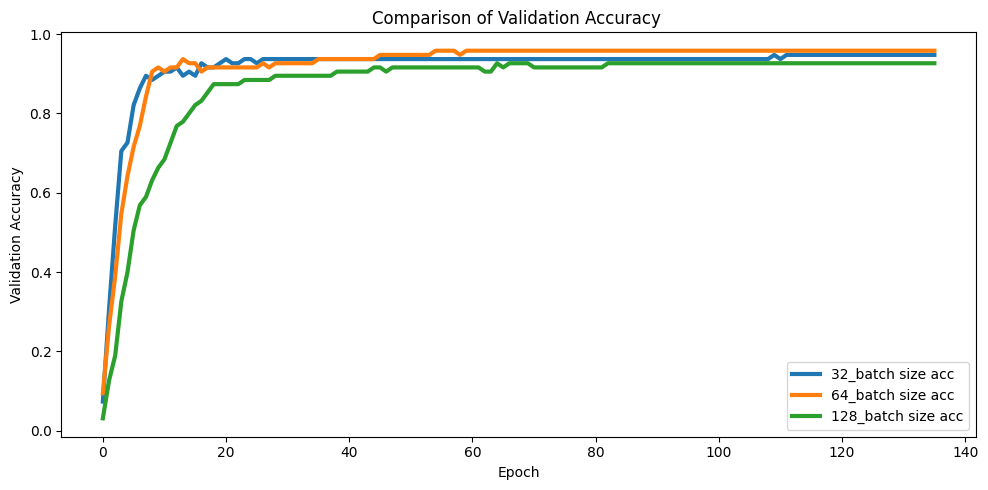

In [ ]:
labl=np.array(['32_batch size acc','64_batch size acc','128_batch size acc'])
graph('val_accuracy','Validation Accuracy','Comparison of Validation Accuracy ', labl)

**128_batch size acheive highest accuracy and lowest loss**



### **2.6.2.Hidden Size**

In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,nodes=512,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 9ms/step - loss: 0.1939 - accuracy: 0.9375
the training accuracy= 1.0
the testing accuracy= 0.9375


(1.0, 0.9375)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,nodes=256,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 9ms/step - loss: 0.1911 - accuracy: 0.9375
the training accuracy= 1.0
the testing accuracy= 0.9375


(1.0, 0.9375)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,nodes=128,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 8ms/step - loss: 0.1433 - accuracy: 0.9688
the training accuracy= 1.0
the testing accuracy= 0.96875


(1.0, 0.96875)

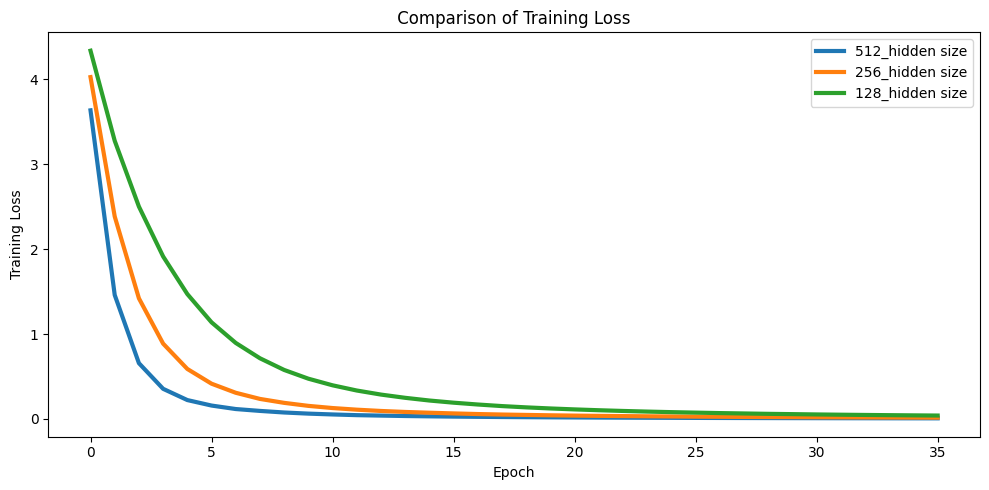

In [ ]:
labl=np.array(['512_hidden size','256_hidden size','128_hidden size'])
graph('loss','Training Loss',' Comparison of Training Loss ',labl)

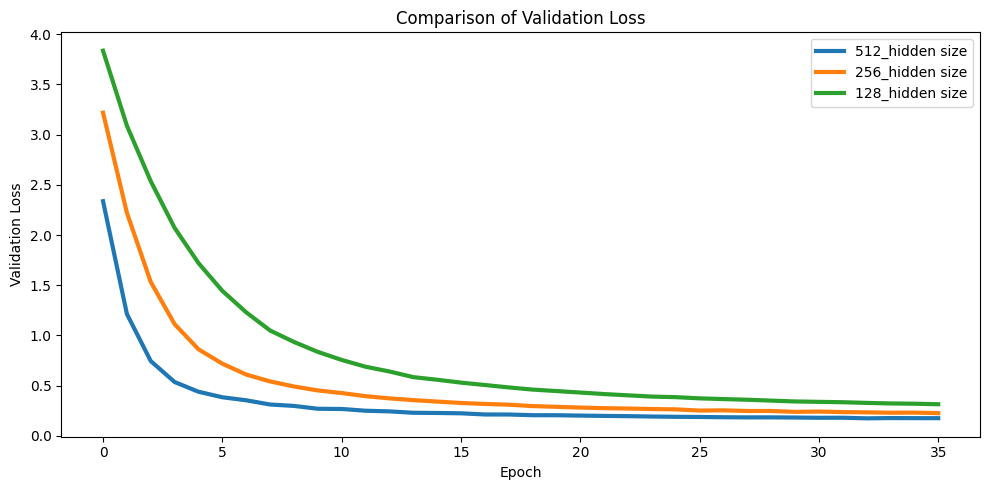

In [ ]:
labl=np.array(['512_hidden size','256_hidden size','128_hidden size'])
graph('val_loss','Validation Loss','Comparison of Validation Loss',labl)

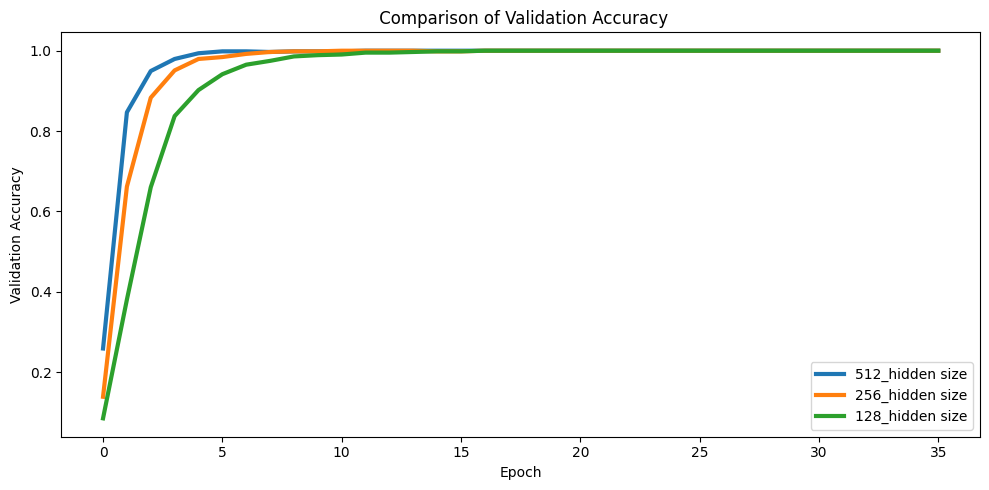

In [ ]:
labl=np.array(['512_hidden size','256_hidden size','128_hidden size'])
graph('accuracy','Validation Accuracy',' Comparison of Validation Accuracy',labl)

**we can see that 512_hidden size acheives high accuracy and low loss very fast**

## **2.6.3.Dropout**
 **:dropping number of neurons to avoid overfitting**

**trying different percentage of dropout to determine the best and if it is helpful for our system or not**

In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,drop=0,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 9ms/step - loss: 0.1754 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,drop=0.25,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 8ms/step - loss: 0.2073 - accuracy: 0.9375
the training accuracy= 1.0
the testing accuracy= 0.9375


(1.0, 0.9375)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,drop=0.5,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 10ms/step - loss: 0.2437 - accuracy: 0.9219
the training accuracy= 1.0
the testing accuracy= 0.921875


(1.0, 0.921875)

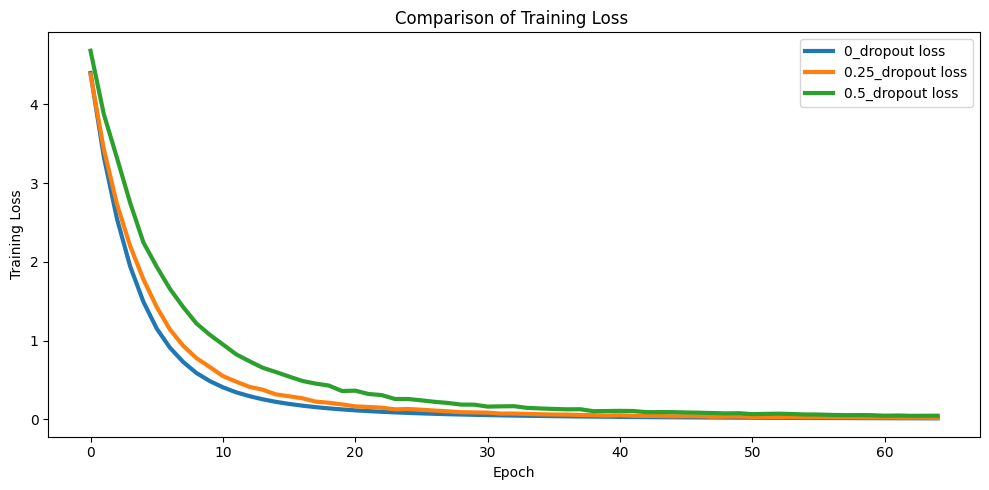

In [ ]:
labl=np.array(['0_dropout loss','0.25_dropout loss','0.5_dropout loss'])
graph('loss','Training Loss','Comparison of Training Loss ', labl)

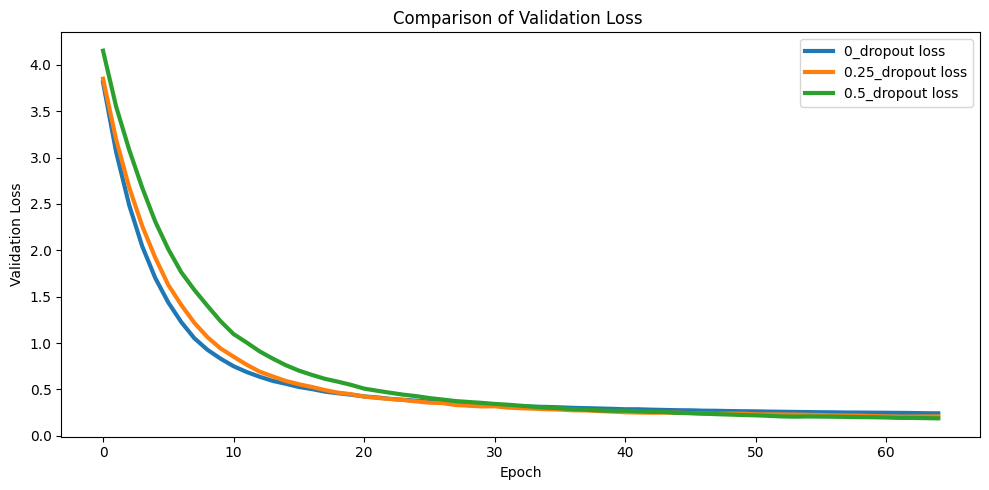

In [ ]:
labl=np.array(['0_dropout loss','0.25_dropout loss','0.5_dropout loss'])
graph('val_loss','Validation Loss','Comparison of Validation Loss ', labl)

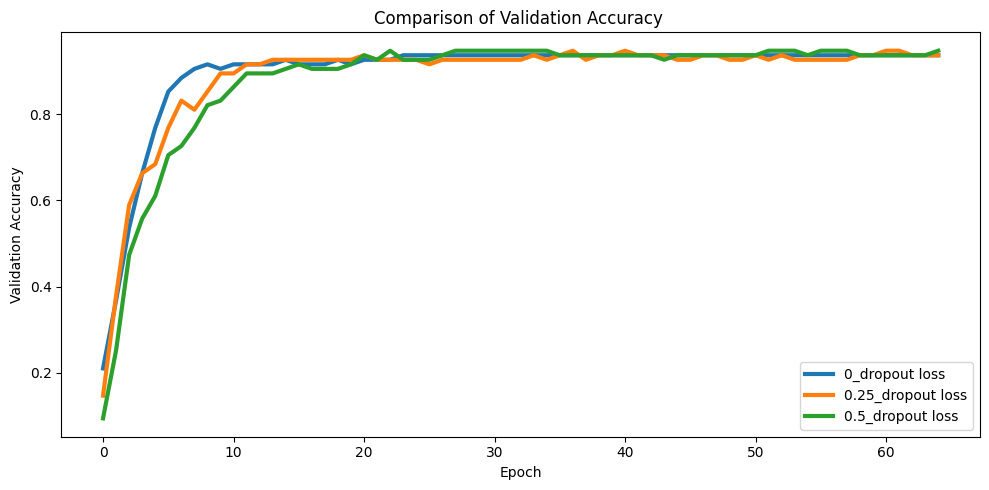

In [ ]:
labl=np.array(['0_dropout loss','0.25_dropout loss','0.5_dropout loss'])
graph('val_accuracy','Validation Accuracy','Comparison of Validation Accuracy ', labl)

we can use 0 dropout as it gives the best reults  

## **2.6.4.Optimizer**
**Comparing between SGD, Adam, RMSProp optimizers**


In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,optimizer=Adam,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 7ms/step - loss: 0.2030 - accuracy: 0.9688
the training accuracy= 1.0
the testing accuracy= 0.96875


(1.0, 0.96875)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,optimizer=SGD,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 8ms/step - loss: 1.7002 - accuracy: 0.7188
the training accuracy= 0.9462875127792358
the testing accuracy= 0.71875


(0.9462875127792358, 0.71875)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,optimizer= RMSprop,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.9375
the training accuracy= 1.0
the testing accuracy= 0.9375


(1.0, 0.9375)

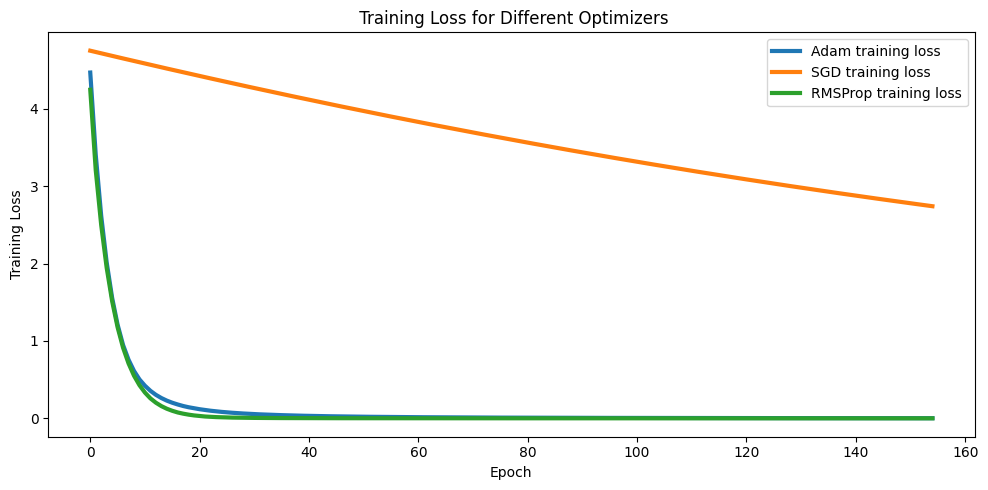

In [ ]:
labl=np.array(['Adam training loss','SGD training loss','RMSProp training loss'])
graph('loss','Training Loss',' Training Loss for Different Optimizers',labl)

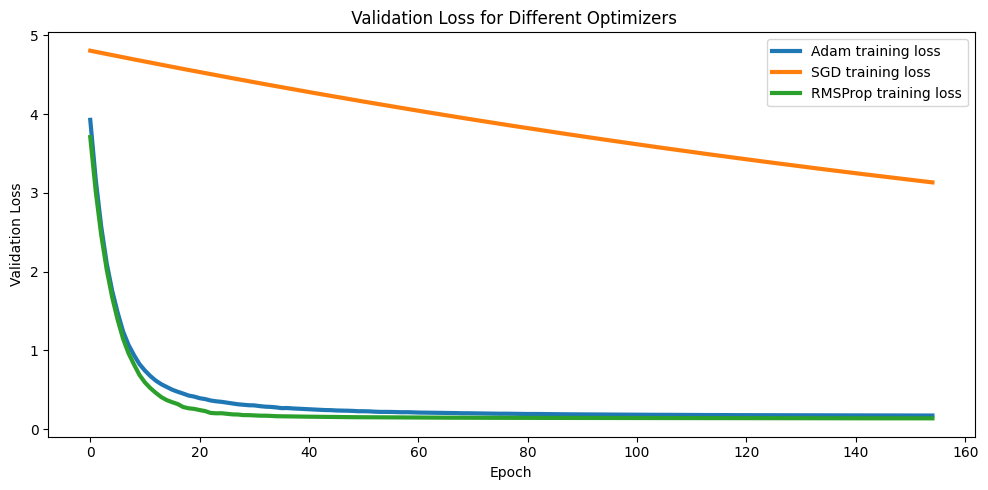

In [ ]:
labl=np.array(['Adam training loss','SGD training loss','RMSProp training loss'])
graph('val_loss','Validation Loss',' Validation Loss for Different Optimizers',labl)

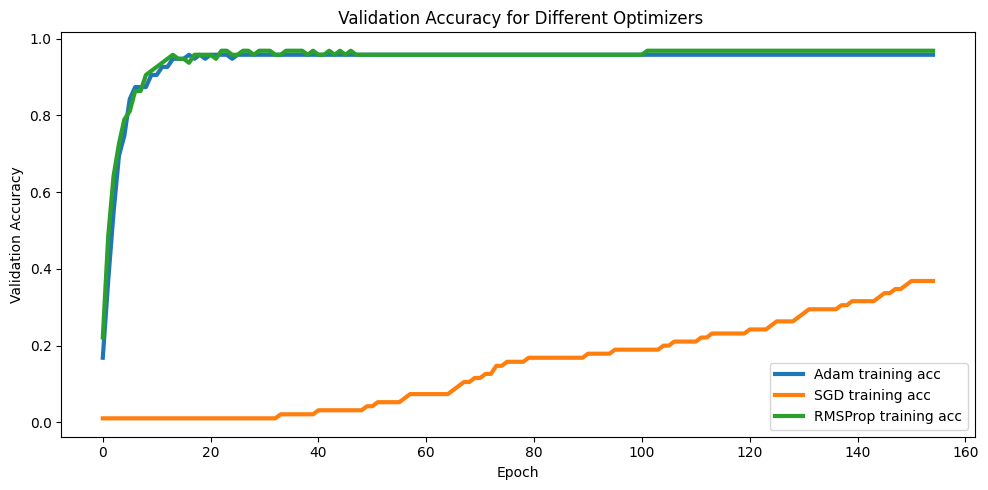

In [ ]:
labl=np.array(['Adam training acc','SGD training acc','RMSProp training acc'])
graph('val_accuracy','Validation Accuracy',' Validation Accuracy for Different Optimizers',labl)

**>>>from results Adam optimizer is the best  so we will use it**

## **2.6.5.Regularization**
**trying different regularization factor`s values**


In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,weight_decay=0,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,weight_decay=0.1,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 8ms/step - loss: 0.7561 - accuracy: 0.9531
the training accuracy= 0.9968404173851013
the testing accuracy= 0.953125


(0.9968404173851013, 0.953125)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,weight_decay=0.2,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 9ms/step - loss: 1.1493 - accuracy: 0.9219
the training accuracy= 0.9968404173851013
the testing accuracy= 0.921875


(0.9968404173851013, 0.921875)

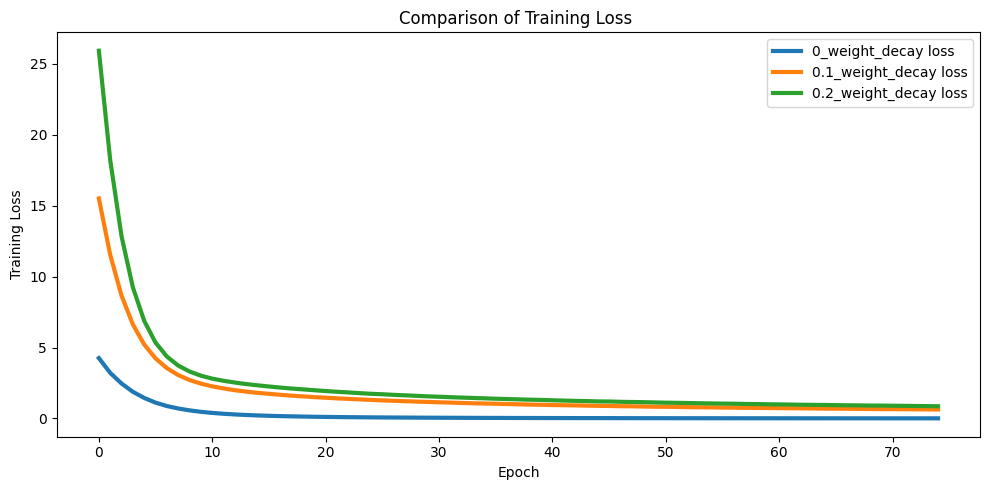

In [ ]:
labl=np.array(['0_weight_decay loss','0.1_weight_decay loss','0.2_weight_decay loss'])
graph('loss','Training Loss','Comparison of Training Loss ', labl)

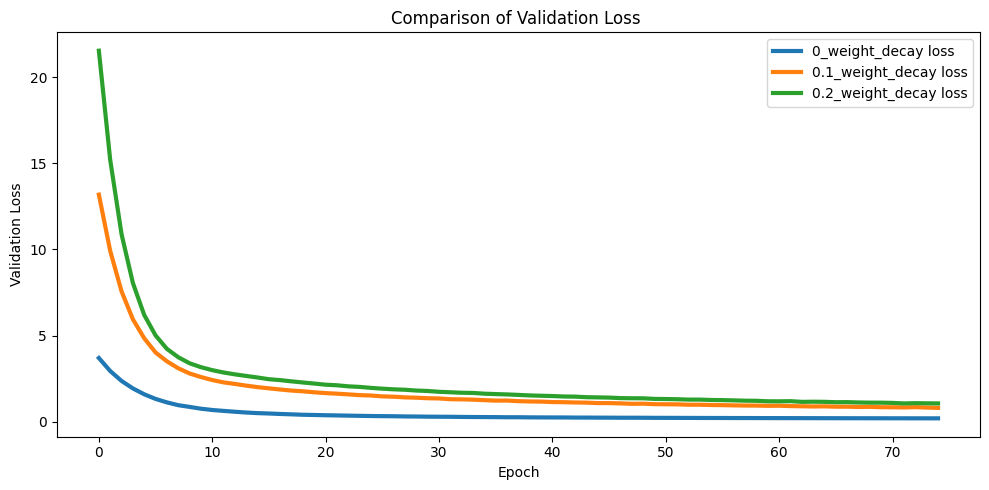

In [ ]:
labl=np.array(['0_weight_decay loss','0.1_weight_decay loss','0.2_weight_decay loss'])
graph('val_loss','Validation Loss','Comparison of Validation Loss ', labl)

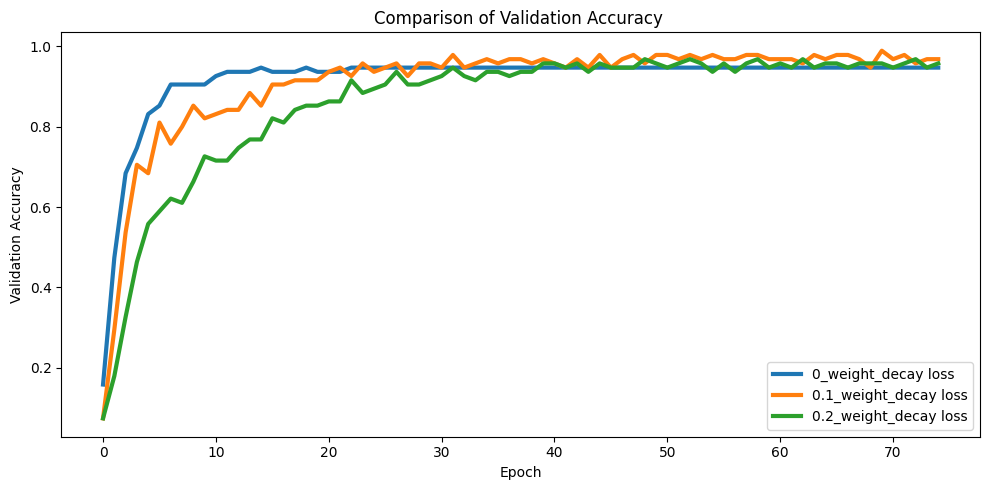

In [ ]:
labl=np.array(['0_weight_decay loss','0.1_weight_decay loss','0.2_weight_decay loss'])
graph('val_accuracy','Validation Accuracy','Comparison of Validation Accuracy ', labl)

**0_Regularization is the best as it is acheiving low loss and  more stable accuracy than the two other values**

## **2.6.6.Learning Rate**

In [ ]:
model0,history0=training(scaled_x_train,scaled_x_val,y_train,y_val,learning_rate=0.001,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model0)

2/2 [==============================] - 0s 9ms/step - loss: 0.2074 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

In [ ]:
model1,history1=training(scaled_x_train,scaled_x_val,y_train,y_val,learning_rate=0.0001,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model1)

2/2 [==============================] - 0s 8ms/step - loss: 0.2319 - accuracy: 0.9531
the training accuracy= 1.0
the testing accuracy= 0.953125


(1.0, 0.953125)

In [ ]:
model2,history2=training(scaled_x_train,scaled_x_val,y_train,y_val,learning_rate=0.00001,epochs=500)
evaluation(scaled_x_train,scaled_x_test,y_train,y_test,model2)

2/2 [==============================] - 0s 9ms/step - loss: 1.8554 - accuracy: 0.6875
the training accuracy= 0.9320695400238037
the testing accuracy= 0.6875


(0.9320695400238037, 0.6875)

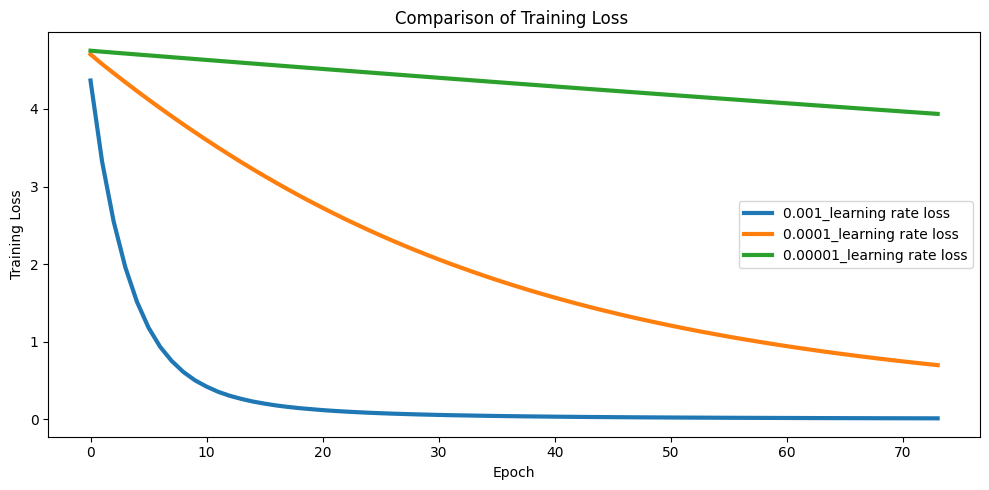

In [ ]:
labl=np.array(['0.001_learning rate loss','0.0001_learning rate loss','0.00001_learning rate loss'])
graph('loss','Training Loss','Comparison of Training Loss ', labl)

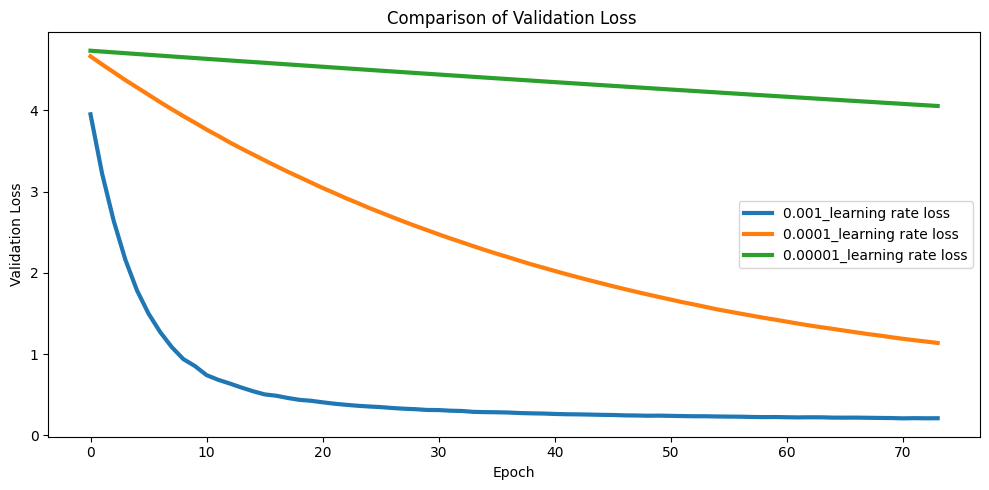

In [ ]:
labl=np.array(['0.001_learning rate loss','0.0001_learning rate loss','0.00001_learning rate loss'])
graph('val_loss','Validation Loss','Comparison of Validation Loss ', labl)

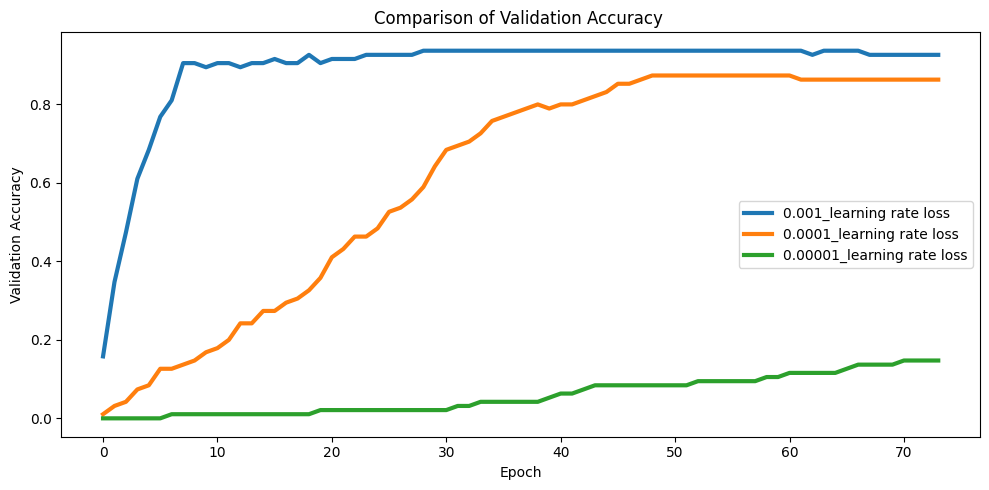

In [ ]:
labl=np.array(['0.001_learning rate loss','0.0001_learning rate loss','0.00001_learning rate loss'])
graph('val_accuracy','Validation Accuracy','Comparison of Validation Accuracy ', labl)

**0.001_learning rate acheived the highest accuracy and the lowest loss so we will use it**